#HarperValleyBank Speech Data Exploration & CTC Implementation


## Setup for Google Drive and Required Libraries

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files.

You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')


DRIVE_PATH = '/content/gdrive/My\ Drive/speech_processing_notes'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/speech_processing_notes'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

Mounted at /content/gdrive


In [4]:
#@title Download HarperValleyBank dataset
#@markdown It takes ~10 minutes to download the dataset. You only need to do this once!

DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harpervalleybank')):
  !wget -q http://web.stanford.edu/class/speech_processing_notes/download/harpervalleybank.zip
  !unzip -q harpervalleybank.zip
  %rm harpervalleybank.zip

/content/gdrive/My Drive/cs224s/data


In [2]:
#@title Import packages
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import os
import json
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from typing import Tuple
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Part 1:  HarperValleyBank Dataset Exploration

Let's first explore the [HarperValleyBank](https://arxiv.org/abs/2010.13929) dataset! The dataset primarily consists of simulated telephone/app-based consumer to banker interactions. For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system.






## Step 1.1 Getting Corpus Statistics [4 Points]

For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system. 

The structure of the HarperValleyBank dataset is:
```
data
    audio
        agent
            <sid1>.wav
            <sid2>.wav
            ...
        caller
            <sid1>.wav
            <sid2>.wav
            ...
    metadata
        <sid1>.json
        <sid2>.json
        ...
    transcript
        <sid1>.json
        <sid2>.json
        ...
```
Every consumer-banker conversation has an id referred to as it' `sid ` .  All associated files are named based on that sid.
Each conversation has four associated files, two audio files, one transcript file and one metadata file.
The audio for each conversation is divided in to two single channel wav files, available under the audio/agent and audio/caller directories.

##### <ins>**Task 1.1.1**</ins>: **Number of conversations** **(2 points)**

Please fill out the function `number_of_conversations` to get the number of conversations in the dataset. (This part could be done with 1 line of code)


In [3]:
agent_audio_path = '/content/speech_processing_notes/data/harpervalleybank/audio/agent/'
caller_audio_path = '/content/speech_processing_notes/data/harpervalleybank/audio/caller/'
transcript_path = '/content/speech_processing_notes/data/harpervalleybank/transcript/'
metadata_path = '/content/speech_processing_notes/data/harpervalleybank/metadata/'

def number_of_conversations(path: str) -> int:
  """Gets number of conversations in the dataset.

  Args:
    path: Path to relevant directory.

  Returns:
    Number of conversations.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  return len(os.listdir(path))
  #############################   

path = transcript_path 
print('Number of conversations: ' + str(number_of_conversations(path)))

Number of conversations: 1446


##### <ins>**Task 1.1.2</ins>: Plot call duration (2 points)**

Please fill out the function `recording_time` to get the duration of recording in seconds and plot a histogram with duration of recording (in seconds) as x-axis and count of conversations as y-axis. You can use `wavfile.read()` method. 

For a single conversation, there are two audio files: `caller` and `agent` audio files. Both audio files for the same conversation have the same duration of recording because the other person's voice is replaced with silence. Thus, please choose either caller or agent directory to get the total duration or recording. 


In [19]:
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
def recording_time(path_dir: str) -> Tuple[float, np.ndarray]:
  """Gets duration of recording
  Args:
    path_dir: Path to relevant directory.

  Returns:
    Duration of total recording in seconds (float),
    Numpy array of duration of recording for all conversations
  
  """
  
  #############################
  #### YOUR CODE GOES HERE ####
  ind_audio_dur = [int(librosa.get_duration(filename=os.path.join(path_dir, file))) for file in os.listdir(path_dir)]
  total_dur = sum(ind_audio_dur)
  return (total_dur, np.array(ind_audio_dur))
  #############################   

path_agent = agent_audio_path 
path_caller = caller_audio_path 

duration, ind_durations = recording_time(path_agent)
print("Total duration of recordings in seconds " + str(duration))

Total duration of recordings in seconds 83410


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


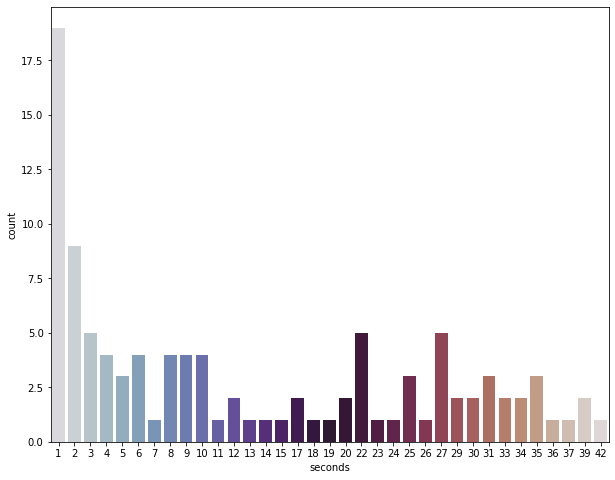

In [40]:
# Plot histogram: X - Duration of recording of individual file, Y - Count of audio files
#############################
#### YOUR CODE GOES HERE ####
import pandas as pd
dur_df = pd.DataFrame({'seconds':ind_durations})
plt.figure(figsize=(10,8))
sns.countplot(dur_df['seconds'].value_counts(), palette='twilight')
#############################

## Step 1.2 Transcript Analysis [16 Points]

**Transcripts:** The transcript json files are lists of segments where each segment is a json object with the following schema:

```json
{
    "channel_index": 2,
    "dialog_acts": [
        "gridspace_greeting"
    ],
    "duration_ms": 2280,
    "emotion": {
        "neutral": 0.33766093850135803,
        "negative": 0.024230705574154854,
        "positive": 0.6381083130836487
    },
    "human_transcript": "hello this is harper valley national bank",
    "index": 1,
    "offset_ms": 5990,
    "speaker_role": "agent",
    "start_ms": 3990,
    "start_timestamp_ms": 1591056064136,
    "transcript": "hello this is harper valley national bank",
    "word_durations_ms": [
        330,
        150,
        120,
        330,
        270,
        420,
        330
    ],
    "word_offsets_ms": [
        0,
        660,
        810,
        930,
        1260,
        1530,
        1950
    ]
}
```
The fields we will closely analyze for inference are:

- **"human_transcript":** Corrected version of the machine genereated "transcript".

- **"emotion":** Softmax output of Gridspace's Emotion model, determining whether the emotional valence of the segment was positive, negative, or neutral.

- **"dialog_acts":**. List of tags assigned to each utterance corresponding to types of conversational move represented in the utterance. There are 16 total dialog actions, and more than one can be present in an utterance. The 16 possible actions are: “yes” response, greeting, response, data confirmation, procedure explanation, data question, closing, data communication, “bear with me” response, acknowledgement, data response, filler disfluency, thanks, open question, problem description, and other.



##### <ins>**Task 1.2.1**</ins>**: Transcript Statistics (2 points)**

Load all transcript json files using `json.load()` and fill out the function `transcript_statistics` to get the following statistics: 
- Total number of utterances
- Mean number of agent utterances per conversation
- Mean number of caller utterances per conversation
- Total number of words: Keep in mind that "[", "]", "<", ">" aren't considered as words. 
- Number of unique words 

You can get the text of the audio file by looking at the **"human_transcript"** field for each transcript. You can use `word_tokenize` function from `nltk.tokenize`.  

In [77]:
def transcript_statistics(
    path_transcript: str) -> Tuple[int, float, float, int, int]:
  """Get transcript statistics.

  Args:
    path_transcript: Path to transcript directory.
  
  Returns:
    Total number of utterances,
    Mean number of agent utterances per conversation,
    Mean number of caller utterances per conversation,
    Total number of words, 
    Number of unique words 
  """
  #############################
  #### YOUR CODE GOES HERE ####
  utt_count = 0
  agent_utt_per_chat = []
  caller_utt_per_chat = []
  total_num_words = 0
  unique_words = set()

  for file in os.listdir(path_transcript):
    with open(os.path.join(path_transcript, file), 'rb') as f:
      chat = json.load(f)

      utt_in_file = []
      agent_utt = 0
      caller_utt = 0

      for utt in chat:
        utt_in_file.append(utt['human_transcript'])
        if utt['speaker_role'] == 'agent':
          agent_utt +=1
        if utt['speaker_role'] == 'caller':
          caller_utt += 1
        
        words = [word for word in word_tokenize(utt['human_transcript']) if word not in ["[", "]", "<", ">"]]
        total_num_words += len(words)
        unique_words.update(set(words))
        
      utt_count += len(utt_in_file)
      agent_utt_per_chat.append(agent_utt)
      caller_utt_per_chat.append(caller_utt)

  return (utt_count, np.mean(agent_utt_per_chat), np.mean(caller_utt_per_chat),
          total_num_words, len(unique_words))
  #############################   

In [78]:
%%time
total_num_utt, agent_utt_per_chat, caller_utt_per_chat, total_num_words, num_unique_words = transcript_statistics(transcript_path)

CPU times: user 6.16 s, sys: 585 ms, total: 6.75 s
Wall time: 13min 7s


In [79]:
print('''
      Total number of utterances: {}
      Mean number of agent utterances per conversation: {}
      Mean number of caller utterances per conversation: {}
      Total number of words: {}
      Number of unique words: {} '''.format(total_num_utt, agent_utt_per_chat, \
                                            caller_utt_per_chat, total_num_words, \
                                            num_unique_words))


      Total number of utterances: 25730
      Mean number of agent utterances per conversation: 9.195712309820193
      Mean number of caller utterances per conversation: 8.59820193637621
      Total number of words: 146853
      Number of unique words: 736 


##### <ins>**Task 1.2.2**</ins>**: Vocabulary Growth (3 points)**

Plot how the vocabulary size (i.e. number of unique words spoken) grows with the number of converations (i.e. transcripts) e.g. with 10\% of the dataset size, what is the vocabulary size? (`X`: Number of transcripts, `Y`: Number of unique words).


In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 1.2.3**</ins>**: Distribution of Utterances (2 points)**

Plot the distribution of number of utterances per conversation and tell us the average number of utterances per conversation. (`X`: Number of utterances in a transcript, `Y`: Number of transcipts with `x` number of utterances)

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 1.2.4**</ins>**: Distribution of Tasks (2 points)**

Plot histogram of the distribution of tasks. The metadata files describe the call center scenario for each converstaion. We will look at **tasks** field for further inference. 

**tasks:** field indicates the customer’s goal/intent in the conversation. There are 8 tasks: _order checks, check balance, replace card, reset password, get branch hours, pay bill, schedule appointment, and transfer money_. (`X`: Eight tasks, `Y`: Number of conversations) 

In [ ]:
task_names = ['order checks', 'check balance', 'replace card', 'reset password', 'get branch hours', 'pay bill', 'schedule appointment', 'transfer money']

#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 1.2.5**</ins>**: Box plots for number of words per coversation split by task (3 points)**

Create a box plot for number of words per conversation. Create a plot for all data. Then split the data by conversation task/intent to create a separate box plot for each. You should create a total of 9 box plots. Comment on your findings, are some tasks quicker than others?

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 1.2.6**</ins>**: Distribution of Dialog Actions (2 points)**

Plot histogram the distribution of dialog actions for utterances. Use **"dialog_acts"** field from each transcript json files. What can you infer from this plot? Please remove "gridspace_" from the labels. (e.g. "greeting" instead of "gridspace_greeting")

(`X`: Dialogue action classes, `Y`: Number of utterances) 

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 1.2.7**</ins>**: Distribution of Emotions (2 points)**

Plot boxplots that show distribution of probabilities for each emotion category across utterances. Use **"emotion"** field from each transcript json files. What can you infer from this plot? (`X`: Emotion Classes, `Y`: Probability) 



In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

# Part 2: Implementing CTC Loss

We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

#### **Summary of CTC**

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly. 

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40. 

#### **Dynamic Programming in CTC**

In class, we introduced the "forward algorithm" to tractably compute likelihoods for HMMs. We can do something similar to score alignments more efficiently than manually enumerating over the full set.

In other words, we can do dynamic programming. Since many alignments share partial sub-sequences, we can  store the `log_prob` for all sub-sequences we have seen so far. This allows us to reuse computation when computing the likelihood for a new sequence.

The logic is as follows:

Recall `X` is the input sequence of maximum length `T` and `Y` is the output sequence of maximum length `S`. Build a new sequence `Z` that adds a blank token between every character. 

```
Y = [y_1, y_2, ..., y_S]
Z = [eps, y_1, eps, y_2, ..., eps, y_S, eps]
  = [z_1, z_2, z_3, z_4, ..., z_2S-1, z_2S, z_2S+1]
```
Note that the length of `Z` is now `2S+1`.

**Step 1: Make a Cache.** 

Instantiate a matrix of size `T x (2S+1)`. Call this matrix `C`. The index `C[t][s]` represents a probability score for the subsequence `z_1, ..., z_s` after observing `x_1, ..., x_t`. That is, `C[t][s] = p(y_1, ..., y_s/2 | x_1, ..., x_t)`.

**Step 2: Make an Update Rule.**

The goal of dynamic programming is to reuse `C[t-1]` in computing `C[t]`. To do that, we need to define an update rule. There are two cases depending on what  the token `z_s` is.

- <ins>Case 1</ins>: `z_s` is a blank token OR `z_s = z_s-2`. This is the standard forward algorithm update. We build `p(z_1, ..., z_s|x_1, ..., x_t)` using two parts: `p(z_1, ..., z_s|x_1, ..., x_t-1)` and `p(z_1, ..., z_s-1|x_1, ..., x_t-1)`. Assuming an increasing order of `t` and `s`, these two parts will already have been computed. (If `s = 0` you can ignore the `C[t-1][s-1]` term. If `t = 0`, set `C[t][s] = p(z_s | x_1, ..., x_t)`.)
```
C[t][s] = (C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```
In other words, `C[t-1][s-1]` and `C[t-1][s]` are known. The prediction for `p(z_s | x_1, ..., x_t)` is known (e.g. `log_probs`).

- <ins>Case 2</ins>: `z_s` is not a blank token AND `z_s != z_s-2`. The tricky part is to notice that `z_s-1` is a blank token. Since our Markov assumption says `y_t` should depend on `y_t-1`, which means `z_s` should depend on both `z_s-1` and `z_s-2` (since we artificially added `z_s-1`). Similarly, ignore terms that do not exist.
```
C[t][s] = (C[t-1][s-2] + C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```

Now, we still need two for loops to loop over `1 ... T` and `1 ... S` but this is usually much cheaper than looping over alignments.

```
C = init_cache(T, S)
for t in 1 to T:
  for s in 1 to 2S+1:
    C = do_update(t, s, C)

p_y_given_x = C[-1][-1] + C[-1][-2]  # sum the probability of the last epsilon and last non-epsilon tokens
```

For more information, refer to this [blog](https://distill.pub/2017/ctc/) or the original [paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf) by Alex Graves.



### **Step 2.1: CTC Objective [15 Points]**

Please write a function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch. We will use this fast library for experiments in HW4.



In [ ]:
def ctc_loss(
    log_probs: torch.FloatTensor, targets: torch.LongTensor,
    input_lengths: torch.LongTensor, target_lengths: torch.LongTensor,
    blank: int = 0) -> torch.Tensor:
  """Connectionist Temporal Classification implementation.

  Args:
    log_probs: The log-beliefs returned by an ASR model.
      This is `log p(a_t | x_1, ..., x_T)`.
      (Shape: T x batch_size x C, where T is a maximum input sequence length and
      C is the alphabet size (including blank))

    targets: Sequence of contiguous output labels (no blanks).
      This is `y_1, ..., y_S`.
      (Shape: batch_size x S, where S is a maximum output sequence length)

    input_lengths: Lengths of each example in minibatch (<= T).
      (Shape: batch_size)

    target_lengths: Lengths of each target in minibatch (<= S).
      (Shape: batch_size)

    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)

  Returns:
    CTC loss averaged over minibatch.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  pass
  #############################
  

Here is a good sanity check. Test you code by checking below that `test` and `soln` are roughly equal. It's okay if your solution is much slower since the Pytorch one is coded in C. However, we will deduct points if you enumerate over all alignments as this is too slow for practical use.



In [ ]:
import torch
import torch.nn.functional as F

log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 50, dtype=torch.long)
target_lengths = torch.randint(10,30,(16,), dtype=torch.long)

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

##### <ins>**Task 2.1.1**</ins>**: Demonstrate your implementation [15 points]**

Print your loss function results on the log_probs and targets we provide. You can load the test minibatches by calling `get_test_minibatches()`.


In [ ]:
import torch
import torch.nn.functional as F
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = np.array([])
  C = np.array([])
  N = np.array([])  
  S = 40  # Target sequence length of longest target in batch (padding length)
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80))
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i])))
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i])))
      
  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long))
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long))
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [ ]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

### Step 2.2: CTC Decoding [15 Points]

Given a sequence of log probabilities ` p_1, ..., p_T,` we often want to decode them to the most likely output sequence `y'_1, y'_2, ..., y'_S`. Ideally, we do this exactly using the Forward-Backward algorithm, but this could be computationally infeasible. A popular thing to do in practice is to use beam search to approximate exact inference. 

Below, you will write a function to decode log probabilities (from a "CTC model") to sequences by beam search. 

For context: to find the maximum likelihood decoding, taking `argmax` at each timestep is not sufficient. Even though CTC assumes conditional independence between characters, greedy decoding does not take into account that multiple output sequences can collapse to the same post-collapsed transcription.

As an example, suppose the pre-collapsed sequences `a a epsilon` and `a a a` are each less likely than the sequence `b b b`. Greedy decoding would pick `b b b` as the most likely sequence. However, since `a a epsilon` and `a a a` collapse to the same string `a`, we can sum their probabilities, which could be more probable than `b b b`. These kind of edge cases make beam search a more effective method for decoding CTC, even without adding a language model.

We strongly recommend you read this [blog](https://distill.pub/2017/ctc), which describes how to do beam search for CTC in detail. As a hint, unlike standard beam search, after choosing the top candidates at every stage, we have to sum the probability for candidates that collapse to the same sequence. This requires you to carefully handle blank tokens (`epsilon`) and repeated tokens.


In [ ]:
import torch

def beam_search(log_probs: torch.LongTensor, beam_width: int = 5) -> list:
  """Beam search to find the most likely sequence.
  
  You can assume the inputs are not in a minibatch (just a single example).
  You can also assume the blank token is index 0.

  Args:
    log_probs: Log probabilities as defined in CTC. (Shape: T x C)
    beam_width: Number of candidates to keep around.
                      
  Returns:
    outputs: [y'_1, y'_2, ..., y'_T], where each y'_t is between 0 and C-1.
             This represents the most likely sequence found by beam search.
      (shape: T) 
  """
  #############################
  #### YOUR CODE GOES HERE ####
  pass
  #############################


def ctc_decode(
    log_probs: torch.LongTensor, blank: int = 0, beam_width: int = 5) -> list:
  """Decoding with CTC.

  Use beam search to approximate the maximum likelihood decoding
  from `log_probs`. Make sure that blank tokens are removed afterwards
  and unnecessary repeated tokens are removed as well.

  Args:
    log_probs: log probabilities as defined in CTC. (shape: T x C)
    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)
    beam_width: The number of candidates to keep around.

  Returns:
    outputs: [y'_1, y'_2, ..., y'_S], where each y'_t is between 0 and C-1.
      (shape: S (!= T))
  """
  #############################
  #### YOUR CODE GOES HERE ####
  pass
  #############################


##### <ins>**Task 2.2.1**</ins>**: Demonstrate beam search decoding [10 points]**

Print the most likely transcript for each `log_probs` and character set we provide. Use the default beam width (=5). You can load the test data  by calling `get_log_probs()`. Please loop through  `log_probs_batch` to get `log_probs` input to test your beam search implementation. You will output 10 likely transcripts by using the test `log_probs` in `log_probs_batch`.

**Note:** The most likely transcript could be gibberish. 

In [ ]:
def get_log_probs() -> torch.LongTensor:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = 50 # input length
  N = 10 # Batch size
  C = 27 # Class size

  # "CTC model" probabilities
  log_probs_batch = torch.randn(N, T, C).log_softmax(2).detach().requires_grad_()
  return log_probs_batch 

log_probs_batch = get_log_probs() # Shape: N x T x C (10, 50, 27)

In [ ]:
import string
log_probs_list = get_log_probs()
char_set = list(string.ascii_lowercase) # lowercase alphabet
char_set.insert(0, "eps") # add blank as the first element

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

##### <ins>**Task 2.2.2**</ins>**: Demonstrate narrowed beam search [5 points]**

Print the most likely transcript for each `log_probs` and character set we provide. Use a narrow beam (=2) and comment on any difference you see with the narrow beam as compared to using the default beam size above. Do you find the same sequences? You can load the test data by calling `get_log_probs()`. Please loop through  `log_probs_batch` to get `log_probs` input to test your implementation. You will output 10 likely transcripts by using the test `log_probs` in `log_probs_batch`.

**Note:** The most likely transcript could be gibberish. 


In [ ]:
import string
log_probs_list = get_log_probs()
char_set = list(string.ascii_lowercase) # lowercase alphabet
char_set.insert(0, "eps") # add blank as the first element
print(char_set)

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
pass
############################# 

This is the end of Part 1 & 2. Great work! 